In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

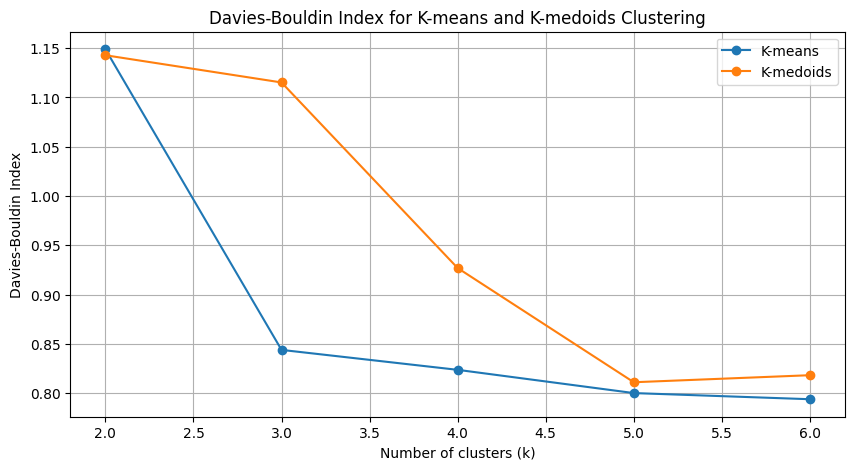

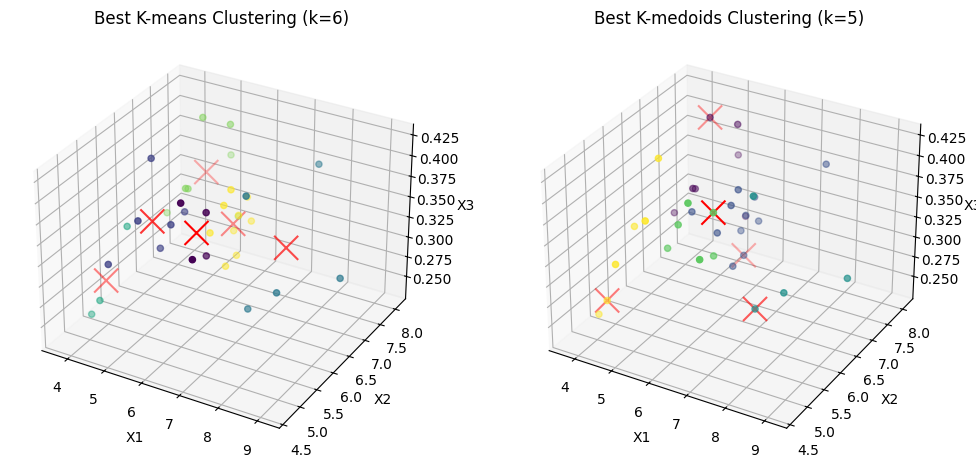

In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the Excel file
file_path = r"E:\GitHub\sherlock-final-project\x_prediction_3.xlsx"
data = pd.read_excel(file_path)

# Select the data from the 103rd to the 136th row (103-based indexing)
data = data.iloc[102:136]

# Extract the features x1, x2, and x3
X = data[['x1', 'x2', 'x3']].to_numpy()

# Initialize lists to store Davies-Bouldin scores
kmeans_scores = []
kmedoids_scores = []

# Store the best models
best_kmeans = None
best_kmedoids = None
best_kmeans_score = float('inf')
best_kmedoids_score = float('inf')
best_kmeans_initial_centroids = None
best_kmeans_final_centroids = None
best_kmedoids_initial_medoids = None
best_kmedoids_final_medoids = None

# Iterate over the number of clusters from 2 to 6
for n_clusters in range(2, 7):
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init='random')
    kmeans.fit(X)
    
    kmeans_initial_centroids = kmeans.get_params  # Capture initial centroids
    kmeans_final_centroids = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_
    kmeans_db_score = davies_bouldin_score(X, kmeans_labels)
    kmeans_scores.append(kmeans_db_score)
    
    if kmeans_db_score < best_kmeans_score:
        best_kmeans_score = kmeans_db_score
        best_kmeans = (n_clusters, kmeans, kmeans_labels)
        best_kmeans_initial_centroids = kmeans_initial_centroids
        best_kmeans_final_centroids = kmeans_final_centroids
    
    # K-medoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0, init='random')
    kmedoids.fit(X)
    
    kmedoids_initial_medoids = kmedoids.get_params  # Capture initial medoids
    kmedoids_final_medoids = kmedoids.cluster_centers_
    kmedoids_labels = kmedoids.labels_
    kmedoids_db_score = davies_bouldin_score(X, kmedoids_labels)
    kmedoids_scores.append(kmedoids_db_score)
    
    if kmedoids_db_score < best_kmedoids_score:
        best_kmedoids_score = kmedoids_db_score
        best_kmedoids = (n_clusters, kmedoids, kmedoids_labels)
        best_kmedoids_initial_medoids = kmedoids_initial_medoids
        best_kmedoids_final_medoids = kmedoids_final_medoids

# Plot the Davies-Bouldin scores for both methods
plt.figure(figsize=(10, 5))
plt.plot(range(2, 7), kmeans_scores, label='K-means', marker='o')
plt.plot(range(2, 7), kmedoids_scores, label='K-medoids', marker='o')
plt.title('Davies-Bouldin Index for K-means and K-medoids Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the best K-means cluster
best_k, best_kmeans_model, best_kmeans_labels = best_kmeans

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_kmeans_labels, cmap='viridis', marker='o')
ax.scatter(best_kmeans_final_centroids[:, 0], 
           best_kmeans_final_centroids[:, 1], 
           best_kmeans_final_centroids[:, 2], 
           s=300, c='red', marker='x')
ax.set_title(f'Best K-means Clustering (k={best_k})')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

# Visualize the best K-medoids cluster
best_k, best_kmedoids_model, best_kmedoids_labels = best_kmedoids

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=best_kmedoids_labels, cmap='viridis', marker='o')
ax.scatter(best_kmedoids_final_medoids[:, 0], 
           best_kmedoids_final_medoids[:, 1], 
           best_kmedoids_final_medoids[:, 2], 
           s=300, c='red', marker='x')
ax.set_title(f'Best K-medoids Clustering (k={best_k})')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.show()
